## Equation Discovery (first attempt + guide notebook)

### Author: Antony Sikorski 

My attempt at rediscovering the parameterization equation for pressure redistribution using high resolution, Large Eddy Simulation (LES) data. 

First, importing necessary libraries: 
- xarray, netcdf, and h5 are all for the data
- PySR is for symbolic regression (equation discovery). Github: https://github.com/MilesCranmer/PySR

In [1]:
import pysr

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Data is in netcdf file format. Files are named according to certain initial conditions that are set: 

- Ug: Imposed wind (large scale wind, geostrophic)
- Q: Surface heating (how much heat you're putting into your domain, initially affects the surface level)
- SI/WI: Strong/Weak Inversion (talking about the temperature inversion that occurs at the top of the ABL, will be visible when looking at the gradient of $\Theta$)

In this notebook, we will open two similar files: 

In [2]:
# all of my LES files are currently stored here
folder_path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim'

file_path_1 = 'Ug2Q024_WI.nc'
file_path_2 = 'Ug2Q024_SI.nc' # strong inversion

df_1 = nc.Dataset(folder_path + '/' + file_path_1, mode='r')
df_2 = nc.Dataset(folder_path + '/' + file_path_2, mode='r')

df_1

# #closing netCDF files since we extracted the data 
# df_1.close()
# df_2.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget

There are three groups which contain different variables: `default`, `thermo`, and `budget`. Typically the temperature terms are found in `thermo` etc. Variables in these groups will have values across two dimensions. 

One of the dimensions is always `time`. Depending on the variables, the other dimensions (height), will either be `z` or `zh`, because some variables are calculated at the center of a cell, other variables are calculate on the surfaces
This is due to the nature of "MicroHH", which is the CFD model we used for simulation. MicroHH is discretized on a staggered Arakawa C-grid, where the scalars are located in the center of a grid cell and the three velocity components are at the faces. Source code for this CFD model: https://github.com/microhh/microhh/tree/main/src

For this dataset, `time` has length 120 (minutes) because there are 2 hours of data. The LES is actually run for 4 hours, but the first two are chopped off. 

The resolution of our LES is $24 \times 24 \times 6$ $ m^3$. I think the variables we get are a result of averaging in the horizontal plane, thus we only retain a height (`z` or `zh`) variable. Let's take a look at all of the variables: 

In [3]:
for group_name, group in df_2.groups.items():
    print(f"Group: {group_name}")
    for var_name, var in group.variables.items():
        long_name = var.getncattr('long_name') if 'long_name' in var.ncattrs() else 'No long_name attribute'
        dimensions = var.dimensions if hasattr(var, 'dimensions') else 'No dimensions attribute'
        print(f"  Variable: {var_name},  Long Name: {long_name},  Dimensions: {dimensions}")

Group: default
  Variable: iter,  Long Name: Iteration number,  Dimensions: ('time',)
  Variable: area,  Long Name: Fractional area contained in mask,  Dimensions: ('time', 'z')
  Variable: areah,  Long Name: Fractional area contained in mask,  Dimensions: ('time', 'zh')
  Variable: eft,  Long Name: eft,  Dimensions: ('time', 'z')
  Variable: eft_3,  Long Name: Moment 3 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_4,  Long Name: Moment 4 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_diff,  Long Name: Diffusive flux of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_w,  Long Name: Turbulent flux of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_grad,  Long Name: Gradient of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_2,  Long Name: Moment 2 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_path,  Long Name: eft path,  Dimensions: ('time',)
  Variable: eft_flux,  Long Name: Total flux of the eft,  Dimensions: ('time', 'zh')
  Variable: sft,  Lo

Let's take a look at some key variables, and try to recreate the figures in *"The non-local character of turbulence asymmetry in the convective atmospheric boundary layer" by Ghannam et al*. Link: https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2937

We will initially focus on $\Theta$, $\frac{\mathrm{d}\Theta}{\mathrm{d}z}$, and $\overline{w' \theta'}$, which are mean potential temperature, its vertical gradient, and then turbulent heat flux, respectively. 

In [4]:
#extract variables from both df, name accordingly
Theta_WI = df_1.groups['thermo'].variables['th']
dTheta_dz_WI = df_1.groups['thermo'].variables['th_grad']
w_theta_WI = df_1.groups['thermo'].variables['th_flux']

Theta_SI = df_2.groups['thermo'].variables['th']
dTheta_dz_SI = df_2.groups['thermo'].variables['th_grad']
w_theta_SI = df_2.groups['thermo'].variables['th_flux']

# couldn't think of how to extract z, zh, t any better so I just did this. 
# someone please do this better 
z = xr.DataArray(Theta_WI, dims=Theta_WI.dimensions)['z'].values
assert(len(z) == 256)
zh = xr.DataArray(w_theta_WI, dims=w_theta_WI.dimensions)['zh'].values
assert(len(zh) == 257)
t = xr.DataArray(Theta_WI, dims=Theta_WI.dimensions)['time'].values
assert(len(t) == 120)

First we look at the unnormalized weak inversion plots of these three key variables:

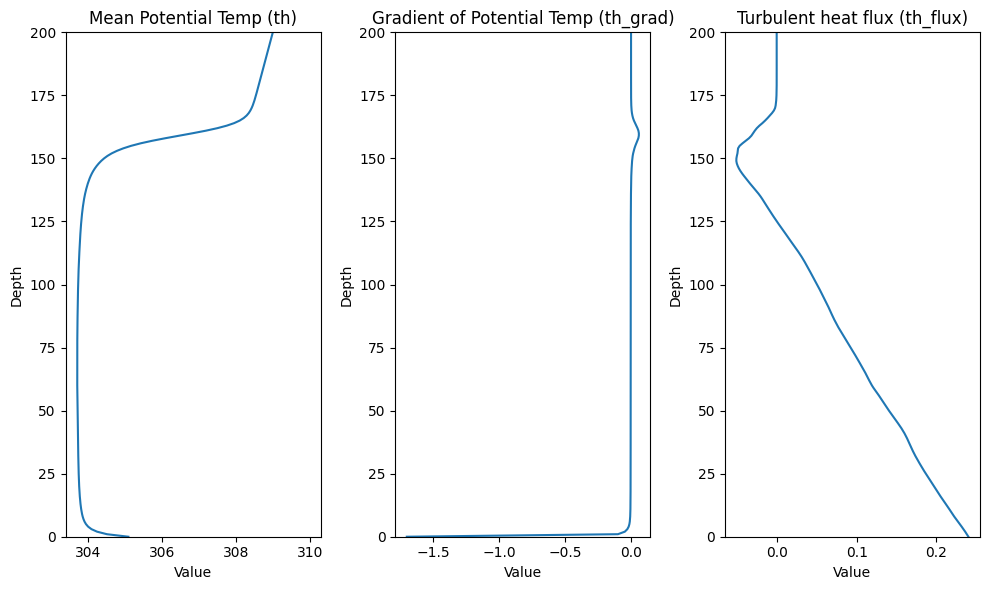

In [5]:
#pick a time at which to plot
timeStep = 60

#pick 'strong' or 'weak' inversion
inversion = 'weak' 

if inversion == 'strong':
    Theta_plot = Theta_SI
    dTheta_dz_plot = dTheta_dz_SI
    w_theta_plot = w_theta_SI
if inversion == 'weak':
    Theta_plot = Theta_WI
    dTheta_dz_plot = dTheta_dz_WI
    w_theta_plot = w_theta_WI

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
plt.plot(Theta_plot[timeStep], np.arange(0, 256))
plt.ylim(0, 200)
plt.title('Mean Potential Temp (th)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
plt.plot(dTheta_dz_plot[timeStep], np.arange(0, 257))
plt.ylim(0, 200)
plt.title('Gradient of Potential Temp (th_grad)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
plt.plot(w_theta_plot[timeStep], np.arange(0, 257))
plt.ylim(0, 200)
plt.title('Turbulent heat flux (th_flux)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Show the plot
plt.tight_layout()
plt.show()

Normalizing the variables following the paper mentioned above in order to get more similar plots. 